# **Package and Source Download**

In [6]:
!pip install datasets
!pip3 install simhash
!pip install pyLDAvis
!pip install simhash

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from simhash import Simhash
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

ds = load_dataset("gfissore/arxiv-abstracts-2021")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Data Cleaning**

In [ ]:
df = pd.DataFrame(ds['train'])

df.head()

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,A fully differential calculation in perturba...,ANL-HEP-PR-07-12,[hep-ph],"[v1, v2]"
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,"We describe a new algorithm, the $(k,\ell)$-...",None,[math.CO cs.CG],"[v1, v2]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,The evolution of Earth-Moon system is descri...,None,[physics.gen-ph],"[v1, v2, v3]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,We show that a determinant of Stirling cycle...,None,[math.CO],[v1]
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,In this paper we show how to compute the $\L...,None,[math.CA math.FA],[v1]


In [ ]:
df['category'] = df['categories'].str[0]

In [ ]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions,category
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,A fully differential calculation in perturba...,ANL-HEP-PR-07-12,[hep-ph],"[v1, v2]",hep-ph
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,"We describe a new algorithm, the $(k,\ell)$-...",None,[math.CO cs.CG],"[v1, v2]",math.CO cs.CG
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,The evolution of Earth-Moon system is descri...,None,[physics.gen-ph],"[v1, v2, v3]",physics.gen-ph
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,We show that a determinant of Stirling cycle...,None,[math.CO],[v1],math.CO
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,In this paper we show how to compute the $\L...,None,[math.CA math.FA],[v1],math.CA math.FA


In [ ]:
df.isnull().sum() / df.count()

,0
id,0.000000
submitter,0.007655
authors,0.000000
title,0.000000
comments,0.281551
journal-ref,1.674071
doi,0.961863
abstract,0.000000
report-no,10.838073
categories,0.000000


In [ ]:
df_use = df[['id','authors','title','abstract','category']]

In [ ]:
df_use['category']

,category
0,hep-ph
1,math.CO cs.CG
2,physics.gen-ph
3,math.CO
4,math.CA math.FA
...,...
1999481,supr-con cond-mat.supr-con
1999482,supr-con cond-mat.supr-con
1999483,supr-con cond-mat.supr-con
1999484,supr-con cond-mat.supr-con


In [ ]:
df_use['category'].value_counts()

,count
category,
astro-ph,86912
hep-ph,76022
quant-ph,58247
hep-th,55058
cs.CV,33669
...,...
stat.AP math.NA q-bio.QM,1
math.OC cs.DC cs.MA stat.ML,1
cond-mat.stat-mech q-bio.MN q-bio.PE q-bio.QM,1


In [ ]:
grouped = df_use.groupby('category')

def sample_rows(group):
  if len(group) > 100 and len(group) < 1000:
    return group.sample(frac=0.001, random_state=42)
  elif len(group) > 999 and len(group) < 10000:
    return group.sample(frac=0.0001, random_state=42)
  elif len(group) > 9999 and len(group) < 100000:
    return group.sample(frac=0.00001, random_state=42)
  else:
    return group

sampled_df = grouped.apply(sample_rows)
sampled_df = sampled_df.reset_index(drop=True)

print(f"Original DataFrame shape: {df_use.shape}")
print(f"Sampled DataFrame shape: {sampled_df.shape}")

sampled_df.head()

<ipython-input-34-c35d0dfb3cb9>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = grouped.apply(sample_rows)


Original DataFrame shape: (1999486, 5)
Sampled DataFrame shape: (274967, 5)


,id,authors,title,abstract,category
0,acc-phys/9505002,"R. Calabrese, V. Guidi, P.Lenisa, E. Mariotti,...",Stroboscopic Laser Diagnostics for Detection o...,A novel diagnostic method for detecting orde...,acc-phys hep-ex physics.acc-ph
1,acc-phys/9607003,"D.H. Brown, D.H. Orlov, G.S. Varner and W.A. W...",A Scintillating Fiber Hodoscope for a Bremstra...,The performance of a scintillating fiber (2m...,acc-phys hep-ex physics.acc-ph
2,acc-phys/9411001,Salman Habib and Robert D. Ryne,Symplectic Computation of Lyapunov Exponents,A recently developed method for the calculat...,acc-phys physics.acc-ph
3,acc-phys/9411002,Patrick L. Nash (University of Texas at San An...,Order $\hbar$ Corrections to the Classical Dyn...,$O(\hbar)$ effects that modify the classical...,acc-phys physics.acc-ph
4,acc-phys/9411003,"C. Travier, L. Boy, J.N. Cayla, B. Leblond, P....",Candela Photo-Injector Experimental Results,The CANDELA photo-injector is a two cell S-b...,acc-phys physics.acc-ph


In [ ]:
category_counts = sampled_df['category'].value_counts()
category_density = category_counts / len(sampled_df)

print(category_counts)
print(category_density)

category
gr-qc math-ph math.DG math.MP          100
q-bio.NC cond-mat.dis-nn               100
math.LO math.RA                        100
physics.bio-ph q-bio.CB                100
math.SG math.AT                        100
                                      ... 
math.DS math.DG math.GT math.SP          1
cs.DC cs.DB cs.PL cs.SE                  1
cs.DC cs.DB cs.PF cs.SI                  1
cs.DC cs.DB cs.OS cs.PL                  1
supr-con cond-mat.supr-con quant-ph      1
Name: count, Length: 67706, dtype: int64
category
gr-qc math-ph math.DG math.MP          0.000364
q-bio.NC cond-mat.dis-nn               0.000364
math.LO math.RA                        0.000364
physics.bio-ph q-bio.CB                0.000364
math.SG math.AT                        0.000364
                                         ...   
math.DS math.DG math.GT math.SP        0.000004
cs.DC cs.DB cs.PL cs.SE                0.000004
cs.DC cs.DB cs.PF cs.SI                0.000004
cs.DC cs.DB cs.OS cs.PL             

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# model_dir = '/content/drive/My Drive/arxiv_sampled.csv'
# data = pd.read_csv(model_dir)
# data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = sampled_df
data = data.sample(frac=0.1, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Text Preprocessing**

In [ ]:
tqdm.pandas()

def preprocess_text_nltk(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

data['processed_abstract'] = list(tqdm(map(preprocess_text_nltk, data['abstract']), total=len(data), desc="Processing Text"))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing Text: 100%|██████████| 48204/48204 [00:53<00:00, 895.43it/s] 


In [ ]:
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,authors,title,abstract,category,processed_abstract
167857,2004.00476,"Christopher W Cleghorn, Belinda Stapelberg",Particle Swarm Optimization: Stability Analysi...,"This paper derives, under minimal modelling ...",cs.NE math.DS,paper derives minimal modelling assumptions si...
408390,1607.08224,Harry Collins,Interactional Expertise and Embodiment,"In Part 1 of this paper, I introduce the ide...",physics.hist-ph physics.soc-ph,part paper introduce idea interactional expert...
288498,0808.3685,Mykhailo Potomkin,Asymptotic behaviour of thermoviscoelastic Ber...,System of partial differential equations wit...,math.DS math.AP,system partial differential equations convolut...
146609,2010.06667,"Vinith M. Suriyakumar, Nicolas Papernot, Anna ...",Chasing Your Long Tails: Differentially Privat...,Machine learning models in health care are o...,cs.LG cs.CR cs.CY stat.ML,machine learning models health care often depl...
47699,1112.0145,"Yuki Nakano, Kenichi Kasamatsu, Tetsuo Matsui",Finite-temperature phase structures of hard-co...,We study finite-temperature phase structures...,cond-mat.quant-gas cond-mat.stat-mech,study finitetemperature phase structures hardc...


# **Deduplication**

In [ ]:
def compute_simhash(text):
    return Simhash(text.split())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def simhash_deduplication(df, simhash_values, threshold=20):

    groups = []
    visited = set()
    group_labels = [None] * len(df)
    representative_abstracts = []

    for idx, simhash in tqdm(enumerate(simhash_values), desc="Grouping Articles"):
        if idx in visited:
            continue

        group = [idx]
        visited.add(idx)

        for other_idx, other_simhash in enumerate(simhash_values):
            if other_idx not in visited and simhash.distance(other_simhash) <= threshold:
                group.append(other_idx)
                visited.add(other_idx)

        groups.append(group)
        representative_abstracts.append(df.iloc[group[0]]['processed_abstract'])

        for member_idx in group:
            group_labels[member_idx] = len(groups)


    df['group_label'] = group_labels
    df['representative_abstract'] = [representative_abstracts[label - 1] if label is not None else None for label in group_labels]

    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
simhash_values = []
for text in tqdm(data['processed_abstract'], desc="Computing SimHash"):
  simhash_values.append(Simhash(text.split()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Computing SimHash: 100%|██████████| 48204/48204 [00:13<00:00, 3499.39it/s]


In [ ]:
data= simhash_deduplication(data, simhash_values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Grouping Articles: 48204it [01:37, 493.90it/s]  


In [ ]:
len(data['group_label'].unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1877

# **Topic Modeling: LDA**

## **Coherence Tuning**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Topics: 2, Coherence Score: 0.2865
Number of Topics: 3, Coherence Score: 0.2946
Number of Topics: 4, Coherence Score: 0.2884
Number of Topics: 5, Coherence Score: 0.2915
Number of Topics: 6, Coherence Score: 0.2984
Number of Topics: 7, Coherence Score: 0.2947
Number of Topics: 8, Coherence Score: 0.3071
Number of Topics: 9, Coherence Score: 0.2965
Number of Topics: 10, Coherence Score: 0.2891


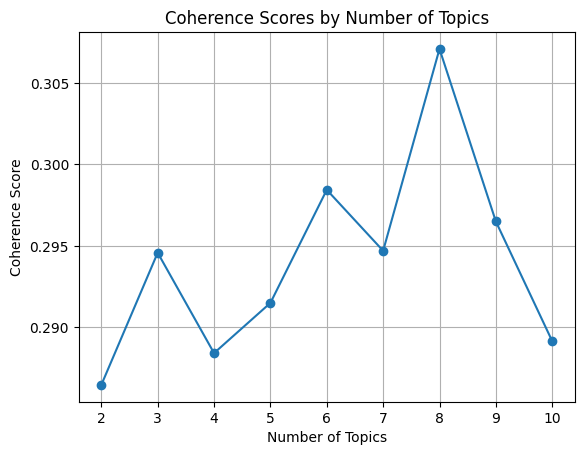

In [27]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


documents = data['representative_abstract'].unique().tolist()


tokenized_docs = [doc.lower().split() for doc in documents]


dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

def compute_coherence_scores(corpus, dictionary, tokenized_docs, start, end, step):
    coherence_scores = []
    topic_range = range(start, end + 1, step)
    for num_topics in topic_range:
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=42,
                             passes=10,
                             alpha='auto')
        coherence_model = CoherenceModel(model=lda_model,
                                         texts=tokenized_docs,
                                         dictionary=dictionary,
                                         coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")
    return coherence_scores

start = 2
end = 10
step = 1
coherence_scores = compute_coherence_scores(corpus, dictionary, tokenized_docs, start, end, step)

topic_numbers, scores = zip(*coherence_scores)
plt.plot(topic_numbers, scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.xticks(topic_numbers)
plt.grid()
plt.show()


## **Process**

In [ ]:
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                stop_words='english',
                                lowercase=True,
                                max_features=30000,
                                token_pattern=r'\b[a-zA-Z]{3,}\b',
                                max_df=0.9,
                                min_df=5,
                                ngram_range=(2, 3))

tf = tf_vectorizer.fit_transform(data['representative_abstract'].unique())
print(tf.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1877, 543)


In [ ]:
lda_tf = LatentDirichletAllocation(n_components=8,
                                   max_iter=50,
                                   learning_method='online',
                                   random_state=40,
                                   learning_decay=0.7,
                                   topic_word_prior=0.01)

with tqdm(total=max_iter, desc="Training LDA") as pbar:
    for _ in range(max_iter):
        lda_tf.partial_fit(tf)
        pbar.update(1)

print("LDA training complete!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Training LDA: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]

LDA training complete!


In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_tf, tf, tf_vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.273746  0.139495       1        1  14.900554
3     -0.094341  0.270833       2        1  13.629179
7     -0.109208 -0.069381       3        1  12.768290
2      0.268202  0.009126       4        1  12.518526
6      0.123373 -0.244823       5        1  12.113464
5     -0.099574  0.042576       6        1  12.009698
1     -0.220576  0.115913       7        1  11.069143
0     -0.141623 -0.263738       8        1  10.991145, topic_info=                       Term       Freq      Total Category  logprob  loglift
286         neural networks  85.000000  85.000000  Default  30.0000  30.0000
244          magnetic field  63.000000  63.000000  Default  29.0000  29.0000
85              dark matter  45.000000  45.000000  Default  28.0000  28.0000
110  differential equations  38.000000  38.000000  Default  27.0000  27.0000
242        machine learning  48.000000  48.000000  Default  26.0000  26.0000
..                      ...        ...        ...      ...      ...      ...
279    necessary conditions   7.224161   7.224293   Topic8  -4.3249   2.2081
366           present paper   7.018027   7.018159   Topic8  -4.3538   2.2081
117       dynamical systems   6.947429   6.947560   Topic8  -4.3639   2.2081
314         order parameter  12.577057  15.106861   Topic8  -3.7704   2.0248
200           hilbert space  11.730020  14.380341   Topic8  -3.8401   2.0044

[319 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1         3  1.070463    additive noise
7         4  0.989727    analysis shows
10        5  1.012683  angular momentum
11        3  1.010994   answer question
15        4  1.027761    approach based
...     ...       ...               ...
538       4  0.432332       widely used
538       5  0.594457       widely used
539       1  0.730242      work propose
539       2  0.243414      work propose
541       7  0.994353         years ago

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 3, 7, 6, 2, 1])

In [ ]:
lda_output = lda_tf.transform(tf)
topic_names = ['Topic ' + str(i) for i in range(lda_tf.n_components)]
article_names = ['group ' + str(i) for i in range(lda_output.shape[0])]
output = pd.DataFrame(np.round(lda_output, 3), columns=topic_names, index=article_names)
output['Dominant Topic'] = np.argmax(lda_output, axis=1)
for i in range(len(output)):
  data.loc[data['group_label']==i, 'Dominant Topic'] = output.iloc[i]['Dominant Topic']
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


            Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  \
group 0       0.125    0.125    0.125    0.125    0.125    0.125    0.125   
group 1       0.063    0.562    0.063    0.063    0.063    0.063    0.063   
group 2       0.891    0.016    0.016    0.016    0.016    0.016    0.016   
group 3       0.014    0.014    0.014    0.014    0.903    0.014    0.014   
group 4       0.161    0.018    0.018    0.018    0.446    0.161    0.018   
...             ...      ...      ...      ...      ...      ...      ...   
group 1872    0.042    0.375    0.042    0.042    0.042    0.042    0.375   
group 1873    0.125    0.125    0.125    0.125    0.125    0.125    0.125   
group 1874    0.063    0.562    0.063    0.063    0.063    0.063    0.063   
group 1875    0.042    0.042    0.042    0.042    0.375    0.042    0.375   
group 1876    0.063    0.063    0.063    0.063    0.063    0.063    0.562   

            Topic 7  Dominant Topic  
group 0       0.125               0  

## **LDA EXAMPLE**

In [ ]:
input_text = "Machine learning models in health care"

input_tf = tf_vectorizer.transform([input_text])

topic_distribution = lda_tf.transform(input_tf)
re = np.argmax(topic_distribution, axis=1)

print("Topic Distribution:", topic_distribution)
print("Topic :", re)

Topic Distribution: [[0.03125    0.03125001 0.03125261 0.03125    0.78124738 0.03125
  0.03125    0.03125   ]]
Topic : [4]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Query Search**

In [ ]:
def predict_topic(tquery, lda_model, tf_vectorizer):


    query_tf = tquery
    topic_distribution = lda_model.transform(query_tf)
    predicted_topic = topic_distribution.argmax()
    return predicted_topic, topic_distribution

def search_within_group(tquery, processed_abstract, tf_vectorizer):

    query_tf = tquery
    group_tf = tf_vectorizer.transform(processed_abstract)
    similarities = cosine_similarity(query_tf, group_tf)
    sorted_indices = np.argsort(similarities[0])[::-1]
    return sorted_indices, similarities[0][sorted_indices]

def query_search(query, lda_tf, tf_vectorizer, dataset, top_n = 10):

    tquery = tf_vectorizer.transform([query])

    # Step 1: Predict dominant topic for the query
    predicted_topic, topic_distribution = predict_topic(tquery, lda_tf, tf_vectorizer)
    print(f"Predicted Topic: {predicted_topic}")

    # Step 2: Filter dataset by predicted topic
    filtered_data = dataset[dataset['Dominant Topic'] == predicted_topic]

    # Step 3: Search within the closest group
    processed_abstract = filtered_data['processed_abstract'].tolist()
    sorted_indices, similarities = search_within_group(tquery, processed_abstract, tf_vectorizer)

    # Step 4: Retrieve ranked results
    results = filtered_data.iloc[sorted_indices]
    results['similarity'] = similarities
    return results[:top_n]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
query = ("I want to find an article that discusses the use of Recurrent Neural "
         "Networks (RNNs) for time-series prediction, particularly focusing on how "
         "LSTMs and GRUs improve performance compared to traditional RNN architectures. "
         "It would be great if the article also includes applications in real-world "
         "scenarios like stock price prediction or weather forecasting.")

search_results = query_search(query, lda_tf, tf_vectorizer, data)
search_results[['title', 'abstract', 'similarity']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Predicted Topic: 4


<ipython-input-213-a78ed527008e>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['similarity'] = similarities


,title,abstract,similarity
156069,A fast noise filtering algorithm for time seri...,Recent research demonstrate that prediction ...,0.801784
478299,Shifting Mean Activation Towards Zero with Bip...,We propose a simple extension to the ReLU-fa...,0.717137
84044,CREW: Computation Reuse and Efficient Weight S...,Deep Neural Networks (DNNs) have achieved tr...,0.623610
167237,Brain-Inspired Learning on Neuromorphic Substr...,Neuromorphic hardware strives to emulate bra...,0.606977
167494,Training recurrent networks online without bac...,"We introduce the ""NoBackTrack"" algorithm to ...",0.585540
